In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
from cmap import Colormap

import torch

mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14

In [3]:
from enum import Enum

class Label(Enum):
    DEEP_BREATH = 0
    DRY_COUGH = 1
    JUMPING_JACK = 2
    PUSH_UP = 3
    SWALLOWING = 4
    THROAT_CLEARING = 5

In [4]:
class BaseLHMDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.shape[0]
    
class LHMMonoDataset(BaseLHMDataset):
    def __getitem__(self, idx):
        return self.features[idx, ...].transpose(0, 1).float(), self.labels[idx]

loader = torch.load('../../dataset/preprocessed/mono_alt.pt')
samples = []
labels = []

for sample, label in loader:
    samples.append(sample.numpy())
    labels.append(label.numpy())

samples = np.array(samples)
labels = np.array(labels)

deep_breath_m = samples[np.where(labels == Label.DEEP_BREATH.value)[0], :, :]
dry_cough_m = samples[np.where(labels == Label.DRY_COUGH.value)[0], :, :]
throat_clearing_m = samples[np.where(labels == Label.THROAT_CLEARING.value)[0], :, :]
swallowing_m = samples[np.where(labels == Label.SWALLOWING.value)[0], :, :]

In [5]:
data = pd.read_csv('interpolated.csv', delimiter=',', header=None).to_numpy()
frames = data[:, 0]
c = data[:, 1]
b = data[:, 2]

discontinuities = np.where(np.diff(frames) != 1)[0] + 1
frame_sections = np.split(frames, discontinuities)
c_sections = np.split(c, discontinuities)
b_sections = np.split(b, discontinuities)

deep_breath = np.column_stack((frame_sections[0], c_sections[0], b_sections[0]))
dry_cough = np.column_stack((frame_sections[1], c_sections[1], b_sections[1]))
throat_clearing = np.column_stack((frame_sections[2], c_sections[2], b_sections[2]))
swallowing = np.column_stack((frame_sections[3], c_sections[3], b_sections[3]))

In [6]:
def load_map(data_directory, direction, timestamp):
    filename = os.path.join(data_directory, str(timestamp) + '-' + direction + '.txt')
    data = pd.read_csv(filename, delimiter=',', header=None).to_numpy()
    data[data == -np.inf] = 0
    return data

data_directory = 'slice_map'
frames = sorted(set(int(name.split('-')[0]) for name in os.listdir(data_directory)))

timestamps = pd.read_csv('timestamps_of_start_peak_end_of_actions.txt', header=None).to_numpy()

src_loc = pd.read_csv('src_loc.txt', delimiter='\t', header=None).to_numpy()
src1 = src_loc[:, :3]
src2 = src_loc[:, 3:]

In [7]:
pv_color = ['#003388', '#2a97e9', '#f06a28', '#7e0000']
timestamps_m = np.arange(0, sample.shape[0], 1)/1000

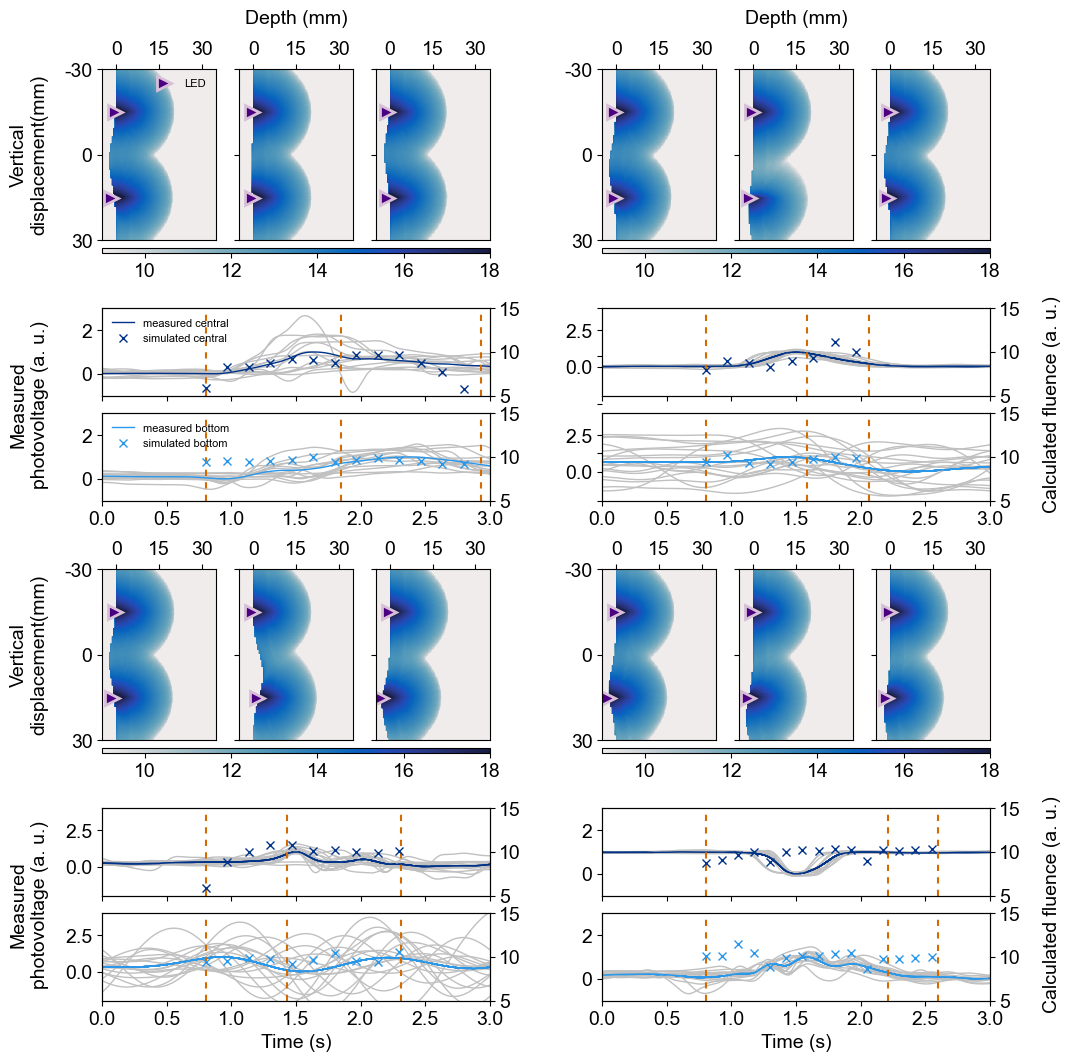

In [18]:
fig = plt.figure(figsize=(10, 10))
subfigs = fig.subfigures(nrows=2, ncols=2, wspace=0, hspace=0.1)

######################
# Deep breath
######################

# Scatter profile
nestedsubfigs = subfigs[0, 0].subfigures(nrows=2, ncols=1, hspace=1)
axes = nestedsubfigs[0].subplots(nrows=1, ncols=3)
# nestedsubfigs[0].suptitle('Deep breath', y=1.2)

for idx, (ax, timestamp) in enumerate(zip(axes, timestamps[:, 0])):

    init_map_x = load_map(data_directory, 'x', timestamp)
    imgx = ax.imshow(init_map_x, cmap=Colormap('cmocean:balance_blue_r').to_matplotlib(),
                     vmin=9, vmax=18)
    srcx1, = ax.plot(src1[frames.index(timestamp), 2], src1[frames.index(timestamp), 1], '>', ms=10, mew=2, c='indigo', mec='thistle', label='LED')
    srcx2, = ax.plot(src2[frames.index(timestamp), 2], src2[frames.index(timestamp), 1], '>', ms=10, mew=2, c='indigo', mec='thistle')
    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.set_xlim([0, 80])
    ax.set_xticks(np.linspace(0, 60, 3) + 10, labels=[0, 15, 30])
    
    if idx == 0:
        ax.set_yticks(np.linspace(0, 120, 3), labels=[-30, 0, 30])
    else:
        ax.set_yticks(np.linspace(0, 120, 3), labels=[])

axes[0].legend(frameon=False, fontsize=8, loc='upper right')
ax_label = nestedsubfigs[0].add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax_label.set_ylabel('Vertical\ndisplacement(mm)')
ax_label.xaxis.set_label_position('top')
ax_label.set_xlabel('Depth (mm)', labelpad=25)

first_ax_pos = axes[0].get_position()
last_ax_pos = axes[-1].get_position()
cbar_ax = nestedsubfigs[0].add_axes([first_ax_pos.x0,
                                     0.1,
                                     last_ax_pos.x0 + last_ax_pos.width - first_ax_pos.x0,
                                     0.02])
cbar = nestedsubfigs[0].colorbar(imgx, cax=cbar_ax, orientation='horizontal')

# Photovoltage
axes = nestedsubfigs[1].subplots(nrows=2, ncols=1, sharex=True, sharey=True) # pvs
for sample in deep_breath_m:
    axes[0].plot(timestamps_m, sample[:, 0],
                 lw=1, c='silver')
    axes[1].plot(timestamps_m, sample[:, 1],
                 lw=1, c='silver')
    axes[1].set_xlim(0, 3)
    axes[1].set_ylim(-1, 3)

axes[0].plot(timestamps_m, np.mean(deep_breath_m, axis=0)[:, 0],
             lw=1, c=pv_color[0], label='measured central')
axes[1].plot(timestamps_m, np.mean(deep_breath_m, axis=0)[:, 1],
             lw=1, c=pv_color[1], label='measured bottom')

axes[0].vlines(x=0.8 + (timestamps[:, 0] - deep_breath[0, 0])/60, ymin=axes[0].get_ylim()[0], ymax=axes[0].get_ylim()[1],
               colors='#D36B00', linestyles=(0, (3, 3)))
axes[1].vlines(x=0.8 + (timestamps[:, 0] - deep_breath[0, 0])/60, ymin=axes[1].get_ylim()[0], ymax=axes[1].get_ylim()[1],
               colors='#D36B00', linestyles=(0, (3, 3)))

# Calculated
ax = axes[0].twinx()
ax.plot(0.8 + (deep_breath[::10, 0] - deep_breath[0, 0])/60, deep_breath[::10, 1],
        'x', c=pv_color[0], label='simulated central')
ax.set_ylim(5, 15)

handles1, labels1 = axes[0].get_legend_handles_labels()
handles2, labels2 = ax.get_legend_handles_labels()
axes[0].legend(handles1 + handles2, labels1 + labels2,
               frameon=False, fontsize=8, loc='upper left')

ax = axes[1].twinx()
ax.plot(0.8 + (deep_breath[::10, 0] - deep_breath[0, 0])/60, deep_breath[::10, 2]*2 - 13.5,
        'x', c=pv_color[1], label='simulated bottom')
ax.set_ylim(5, 15)
handles1, labels1 = axes[1].get_legend_handles_labels()
handles2, labels2 = ax.get_legend_handles_labels()
axes[1].legend(handles1 + handles2, labels1 + labels2,
               frameon=False, fontsize=8, loc='upper left')

ax_label = nestedsubfigs[1].add_subplot(111, frameon=False)
plt.tick_params(color='none', labelcolor='none', top=False, bottom=False, left=False, right=False)
ax_label.set_ylabel('Measured\nphotovoltage (a. u.)')
# ax_label.xaxis.set_label_position('bottom')
# ax_label.set_xlabel('Time (s)')

ax_label = ax_label.twinx()
plt.tick_params(color='none', labelcolor='none', top=False, bottom=False, left=False, right=False)
# ax_label.set_ylabel('Calculated fluence (a. u.)')
sns.despine(ax=ax_label, left=True, bottom=True, right=True, top=True)

######################
# Dry cough
######################
nestedsubfigs = subfigs[0, 1].subfigures(nrows=2, ncols=1, hspace=0.08)
axes = nestedsubfigs[0].subplots(nrows=1, ncols=3) # maps
# nestedsubfigs[0].suptitle('Dry cough', y=1.2)

for idx, (ax, timestamp) in enumerate(zip(axes, timestamps[:, 1])):

    init_map_x = load_map(data_directory, 'x', timestamp)
    imgx = ax.imshow(init_map_x, cmap=Colormap('cmocean:balance_blue_r').to_matplotlib(),
                     vmin=9, vmax=18)
    srcx1, = ax.plot(src1[frames.index(timestamp), 2], src1[frames.index(timestamp), 1], '>', ms=10, mew=2, c='indigo', mec='thistle')
    srcx2, = ax.plot(src2[frames.index(timestamp), 2], src2[frames.index(timestamp), 1], '>', ms=10, mew=2, c='indigo', mec='thistle')
    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.set_xlim([0, 80])
    ax.set_xticks(np.linspace(0, 60, 3) + 10, labels=[0, 15, 30])
    
    if idx == 0:
        ax.set_yticks(np.linspace(0, 120, 3), labels=[-30, 0, 30])
    else:
        ax.set_yticks(np.linspace(0, 120, 3), labels=[])

ax_label = nestedsubfigs[0].add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# ax_label.set_ylabel('Vertical\ndisplacement\n(mm)')
ax_label.xaxis.set_label_position('top')
ax_label.set_xlabel('Depth (mm)', labelpad=25)

first_ax_pos = axes[0].get_position()
last_ax_pos = axes[-1].get_position()
cbar_ax = nestedsubfigs[0].add_axes([first_ax_pos.x0,
                                     0.1,
                                     last_ax_pos.x0 + last_ax_pos.width - first_ax_pos.x0,
                                     0.02])
nestedsubfigs[0].colorbar(imgx, cax=cbar_ax, orientation='horizontal')

axes = nestedsubfigs[1].subplots(nrows=2, ncols=1, sharex=True, sharey=True) # pvs
for sample in dry_cough_m:
    axes[0].plot(timestamps_m, sample[:, 0],
                 lw=1, c='silver')
    axes[0].plot(timestamps_m, np.mean(dry_cough_m, axis=0)[:, 0],
                 lw=1, c=pv_color[0])
    axes[1].plot(timestamps_m, sample[:, 1],
                 lw=1, c='silver')
    axes[1].plot(timestamps_m, np.mean(dry_cough_m, axis=0)[:, 1],
                 lw=1, c=pv_color[1])
    axes[1].set_xlim(0, 3)
    axes[1].set_ylim(-2, 4)

axes[0].vlines(x=0.8 + (timestamps[:, 1] - dry_cough[0, 0])/60, ymin=axes[0].get_ylim()[0], ymax=axes[0].get_ylim()[1],
               colors='#D36B00', linestyles=(0, (3, 3)))
axes[1].vlines(x=0.8 + (timestamps[:, 1] - dry_cough[0, 0])/60, ymin=axes[1].get_ylim()[0], ymax=axes[1].get_ylim()[1],
               colors='#D36B00', linestyles=(0, (3, 3)))

ax = axes[0].twinx()
ax.plot(0.8 + (dry_cough[::10, 0] - dry_cough[0, 0])/60, dry_cough[::10, 1],
        'x', c=pv_color[0])
ax.set_ylim(5, 15)

ax = axes[1].twinx()
ax.plot(0.8 + (dry_cough[::10, 0] - dry_cough[0, 0])/60, dry_cough[::10, 2]*2 - 13.5,
        'x', c=pv_color[1])
ax.set_ylim(5, 15)

ax_label = nestedsubfigs[1].add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# ax_label.set_ylabel('Measured photovoltage (a. u.)')
# ax_label.xaxis.set_label_position('bottom')
# ax_label.set_xlabel('Time (s)')

ax_label = ax_label.twinx()
plt.tick_params(color='none', labelcolor='none', top=False, bottom=False, left=False, right=False)
ax_label.set_ylabel('Calculated fluence (a. u.)')
sns.despine(ax=ax_label, left=True, bottom=True, right=True, top=True)

######################
# Throat clearing
######################

nestedsubfigs = subfigs[1, 0].subfigures(nrows=2, ncols=1, hspace=0.08)
axes = nestedsubfigs[0].subplots(nrows=1, ncols=3) # maps
# nestedsubfigs[0].suptitle('Throat clearing', y=1.1)

for idx, (ax, timestamp) in enumerate(zip(axes, timestamps[:, 2])):

    init_map_x = load_map(data_directory, 'x', timestamp)
    imgx = ax.imshow(init_map_x, cmap=Colormap('cmocean:balance_blue_r').to_matplotlib(),
                     vmin=9, vmax=18)
    srcx1, = ax.plot(src1[frames.index(timestamp), 2], src1[frames.index(timestamp), 1], '>', ms=10, mew=2, c='indigo', mec='thistle')
    srcx2, = ax.plot(src2[frames.index(timestamp), 2], src2[frames.index(timestamp), 1], '>', ms=10, mew=2, c='indigo', mec='thistle')
    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.set_xlim([0, 80])
    ax.set_xticks(np.linspace(0, 60, 3) + 10, labels=[0, 15, 30])
    
    if idx == 0:
        ax.set_yticks(np.linspace(0, 120, 3), labels=[-30, 0, 30])
    else:
        ax.set_yticks(np.linspace(0, 120, 3), labels=[])

ax_label = nestedsubfigs[0].add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax_label.set_ylabel('Vertical\ndisplacement(mm)')
# ax_label.xaxis.set_label_position('top')
# ax_label.set_xlabel('Depth (mm)', labelpad=10)

first_ax_pos = axes[0].get_position()
last_ax_pos = axes[-1].get_position()
cbar_ax = nestedsubfigs[0].add_axes([first_ax_pos.x0,
                                     0.1,
                                     last_ax_pos.x0 + last_ax_pos.width - first_ax_pos.x0,
                                     0.02])
nestedsubfigs[0].colorbar(imgx, cax=cbar_ax, orientation='horizontal')

axes = nestedsubfigs[1].subplots(nrows=2, ncols=1, sharex=True, sharey=True) # pvs
for sample in throat_clearing_m:
    axes[0].plot(timestamps_m, sample[:, 0],
                 lw=1, c='silver')
    axes[0].plot(timestamps_m, np.mean(throat_clearing_m, axis=0)[:, 0],
                 lw=1, c=pv_color[0])
    axes[1].plot(timestamps_m, sample[:, 1],
                 lw=1, c='silver')
    axes[1].plot(timestamps_m, np.mean(throat_clearing_m, axis=0)[:, 1],
                 lw=1, c=pv_color[1])
    axes[1].set_xlim(0, 3)
    axes[1].set_ylim(-2, 4)

axes[0].vlines(x=0.8 + (timestamps[:, 2] - throat_clearing[0, 0])/60, ymin=axes[0].get_ylim()[0], ymax=axes[0].get_ylim()[1],
               colors='#D36B00', linestyles=(0, (3, 3)))
axes[1].vlines(x=0.8 + (timestamps[:, 2] - throat_clearing[0, 0])/60, ymin=axes[1].get_ylim()[0], ymax=axes[1].get_ylim()[1],
               colors='#D36B00', linestyles=(0, (3, 3)))

ax = axes[0].twinx()
ax.plot(0.8 + (throat_clearing[::10, 0] - throat_clearing[0, 0])/60, throat_clearing[::10, 1],
        'x', c=pv_color[0])
ax.set_ylim(5, 15)

ax = axes[1].twinx()
ax.plot(0.8 + (throat_clearing[::10, 0] - throat_clearing[0, 0])/60, throat_clearing[::10, 2]*2 - 13.5,
        'x', c=pv_color[1])
ax.set_ylim(5, 15)

ax_label = nestedsubfigs[1].add_subplot(111, frameon=False)
plt.tick_params(color='none', labelcolor='none', top=False, bottom=False, left=False, right=False)
ax_label.set_ylabel('Measured\nphotovoltage (a. u.)')
ax_label.xaxis.set_label_position('bottom')
ax_label.set_xlabel('Time (s)')

ax_label = ax_label.twinx()
plt.tick_params(color='none', labelcolor='none', top=False, bottom=False, left=False, right=False)
# ax_label.set_ylabel('Calculated fluence (a. u.)')
sns.despine(ax=ax_label, left=True, bottom=True, right=True, top=True)

######################
# Swallowing
######################
nestedsubfigs = subfigs[1, 1].subfigures(nrows=2, ncols=1, hspace=0.08)
axes = nestedsubfigs[0].subplots(nrows=1, ncols=3) # maps
# nestedsubfigs[0].suptitle('Swallowing', y=1.1)

for idx, (ax, timestamp) in enumerate(zip(axes, timestamps[:, 3])):

    init_map_x = load_map(data_directory, 'x', timestamp)
    imgx = ax.imshow(init_map_x, cmap=Colormap('cmocean:balance_blue_r').to_matplotlib(),
                     vmin=9, vmax=18)
    srcx1, = ax.plot(src1[frames.index(timestamp), 2], src1[frames.index(timestamp), 1], '>', ms=10, mew=2, c='indigo', mec='thistle')
    srcx2, = ax.plot(src2[frames.index(timestamp), 2], src2[frames.index(timestamp), 1], '>', ms=10, mew=2, c='indigo', mec='thistle')
    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.set_xlim([0, 80])
    ax.set_xticks(np.linspace(0, 60, 3) + 10, labels=[0, 15, 30])
    
    if idx == 0:
        ax.set_yticks(np.linspace(0, 120, 3), labels=[-30, 0, 30])
    else:
        ax.set_yticks(np.linspace(0, 120, 3), labels=[])

ax_label = nestedsubfigs[0].add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# ax_label.set_ylabel('Vertical\ndisplacement\n(mm)')
# ax_label.xaxis.set_label_position('top')
# ax_label.set_xlabel('Depth (mm)', labelpad=10)

first_ax_pos = axes[0].get_position()
last_ax_pos = axes[-1].get_position()
cbar_ax = nestedsubfigs[0].add_axes([first_ax_pos.x0,
                                     0.1,
                                     last_ax_pos.x0 + last_ax_pos.width - first_ax_pos.x0,
                                     0.02])
nestedsubfigs[0].colorbar(imgx, cax=cbar_ax, orientation='horizontal')

axes = nestedsubfigs[1].subplots(nrows=2, ncols=1, sharex=True, sharey=True) # pvs
for sample in swallowing_m:
    axes[0].plot(timestamps_m, sample[:, 0],
                 lw=1, c='silver')
    axes[0].plot(timestamps_m, np.mean(swallowing_m, axis=0)[:, 0],
                 lw=1, c=pv_color[0])
    axes[1].plot(timestamps_m, sample[:, 1],
                 lw=1, c='silver')
    axes[1].plot(timestamps_m, np.mean(swallowing_m, axis=0)[:, 1],
                 lw=1, c=pv_color[1])
    axes[1].set_xlim(0, 3)
    axes[1].set_ylim(-1, 3)

axes[0].vlines(x=0.8 + (timestamps[:, 3] - swallowing[0, 0])/80, ymin=axes[0].get_ylim()[0], ymax=axes[0].get_ylim()[1],
               colors='#D36B00', linestyles=(0, (3, 3)))
axes[1].vlines(x=0.8 + (timestamps[:, 3] - swallowing[0, 0])/80, ymin=axes[1].get_ylim()[0], ymax=axes[1].get_ylim()[1],
               colors='#D36B00', linestyles=(0, (3, 3)))

ax = axes[0].twinx()
ax.plot(0.8 + (swallowing[::10, 0] - swallowing[0, 0])/80, swallowing[::10, 1],
        'x', c=pv_color[0])
ax.set_ylim(5, 15)

ax = axes[1].twinx()
ax.plot(0.8 + (swallowing[::10, 0] - swallowing[0, 0])/80, swallowing[::10, 2]*2 - 13.5,
        'x', c=pv_color[1])
ax.set_ylim(5, 15)

ax_label = nestedsubfigs[1].add_subplot(111, frameon=False)
plt.tick_params(color='none', labelcolor='none', top=False, bottom=False, left=False, right=False)
# ax_label.set_ylabel('Measured photovoltage (a. u.)')
ax_label.xaxis.set_label_position('bottom')
ax_label.set_xlabel('Time (s)')

ax_label = ax_label.twinx()
plt.tick_params(color='none', labelcolor='none', top=False, bottom=False, left=False, right=False)
ax_label.set_ylabel('Calculated fluence (a. u.)')
sns.despine(ax=ax_label, left=True, bottom=True, right=True, top=True)

plt.savefig('../fig5/all.png', bbox_inches='tight', dpi=600)
plt.show()

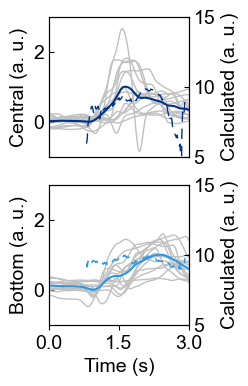

In [18]:
fig = plt.figure(figsize=(1.8, 4))

ax1_c = fig.add_subplot(211)
for sample in deep_breath_m:
    ax1_c.plot(timestamps_m, sample[:, 0],
            lw=1, c='silver')
ax1_c.plot(timestamps_m, np.mean(deep_breath_m, axis=0)[:, 0],
         lw=1.5, c=pv_color[0])    
ax1_c.set_xlim(0, 3)
ax1_c.set_ylim(-1, 3)
ax1_c.set_xticks([])
ax1_c.tick_params(axis='y', direction='in')
ax1_c.set_ylabel('Central (a. u.)')

ax2_c = ax1_c.twinx()
ax2_c.plot(0.8 + (deep_breath[:, 0] - deep_breath[0, 0])/60, deep_breath[:, 1],
         lw=1, ls=(0, (7.5, 5)), c=pv_color[0])
ax2_c.set_ylim(5, 15)
ax2_c.tick_params(axis='y', direction='in')
ax2_c.set_ylabel('Calculated (a. u.)')

ax1_b = fig.add_subplot(212)
for sample in deep_breath_m:
    ax1_b.plot(timestamps_m, sample[:, 1],
            lw=1, c='silver')
ax1_b.plot(timestamps_m, np.mean(deep_breath_m, axis=0)[:, 1],
         lw=1.5, c=pv_color[1])    
ax1_b.set_xlim(0, 3)
ax1_b.set_ylim(-1, 3)
ax1_b.set_xticks([0, 1.5, 3])
ax1_b.set_xlabel('Time (s)')
ax1_b.tick_params(axis='y', direction='in')
ax1_b.set_ylabel('Bottom (a. u.)')

ax2_b = ax1_b.twinx()
ax2_b.plot(0.8 + (deep_breath[:, 0] - deep_breath[0, 0])/60, deep_breath[:, 2]*2 - 13.5,
         lw=1, ls=(0, (7.5, 5)), c=pv_color[1])
ax2_b.set_ylim(5, 15)
ax2_b.tick_params(axis='y', direction='in')
ax2_b.set_ylabel('Calculated (a. u.)')

# plt.savefig('deep_breath.png', dpi=600, bbox_inches='tight')
plt.show()

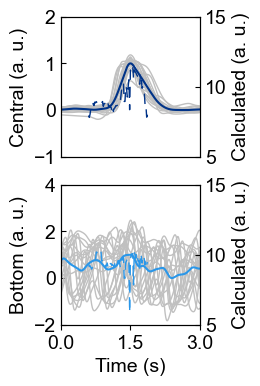

In [108]:
fig = plt.figure(figsize=(1.8, 4))

ax1_c = fig.add_subplot(211)
for sample in dry_cough_m:
    ax1_c.plot(timestamps_m, sample[:, 0],
            lw=1, c='silver')
ax1_c.plot(timestamps_m, np.mean(dry_cough_m, axis=0)[:, 0],
         lw=1.5, c=pv_color[0])    
ax1_c.set_xlim(0, 3)
ax1_c.set_ylim(-1, 2)
ax1_c.set_xticks([])
ax1_c.tick_params(axis='y', direction='in')
ax1_c.set_ylabel('Central (a. u.)')

ax2_c = ax1_c.twinx()
ax2_c.plot(0.6 + (dry_cough[:, 0] - dry_cough[0, 0])/60, dry_cough[:, 1],
         lw=1, ls=(0, (7.5, 5)), c=pv_color[0])
ax2_c.set_ylim(5, 15)
ax2_c.tick_params(axis='y', direction='in')
ax2_c.set_ylabel('Calculated (a. u.)')

ax1_b = fig.add_subplot(212)
for sample in dry_cough_m:
    ax1_b.plot(timestamps_m, sample[:, 1],
            lw=1, c='silver')
ax1_b.plot(timestamps_m, np.mean(dry_cough_m, axis=0)[:, 1],
         lw=1.5, c=pv_color[1])    
ax1_b.set_xlim(0, 3)
ax1_b.set_ylim(-2, 4)
ax1_b.set_xticks([0, 1.5, 3])
ax1_b.set_xlabel('Time (s)')
ax1_b.tick_params(axis='y', direction='in')
ax1_b.set_ylabel('Bottom (a. u.)')

ax2_b = ax1_b.twinx()
ax2_b.plot(0.6 + (dry_cough[:, 0] - dry_cough[0, 0])/60, dry_cough[:, 2]*2 - 13.5,
         lw=1, ls=(0, (7.5, 5)), c=pv_color[1])
ax2_b.set_ylim(5, 15)
ax2_b.tick_params(axis='y', direction='in')
ax2_b.set_ylabel('Calculated (a. u.)')

plt.savefig('dry_cough.png', dpi=600, bbox_inches='tight')
plt.show()

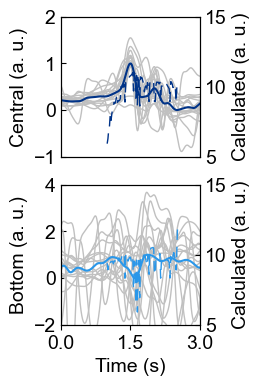

In [112]:
fig = plt.figure(figsize=(1.8, 4))

ax1_c = fig.add_subplot(211)
for sample in throat_clearing_m:
    ax1_c.plot(timestamps_m, sample[:, 0],
            lw=1, c='silver')
ax1_c.plot(timestamps_m, np.mean(throat_clearing_m, axis=0)[:, 0],
         lw=1.5, c=pv_color[0])    
ax1_c.set_xlim(0, 3)
ax1_c.set_ylim(-1, 2)
ax1_c.set_xticks([])
ax1_c.tick_params(axis='y', direction='in')
ax1_c.set_ylabel('Central (a. u.)')

ax2_c = ax1_c.twinx()
ax2_c.plot(1 + (throat_clearing[:, 0] - throat_clearing[0, 0])/60, throat_clearing[:, 1],
         lw=1, ls=(0, (7.5, 5)), c=pv_color[0])
ax2_c.set_ylim(5, 15)
ax2_c.tick_params(axis='y', direction='in')
ax2_c.set_ylabel('Calculated (a. u.)')

ax1_b = fig.add_subplot(212)
for sample in throat_clearing_m:
    ax1_b.plot(timestamps_m, sample[:, 1],
            lw=1, c='silver')
ax1_b.plot(timestamps_m, np.mean(throat_clearing_m, axis=0)[:, 1],
         lw=1.5, c=pv_color[1])    
ax1_b.set_xlim(0, 3)
ax1_b.set_ylim(-2, 4)
ax1_b.set_xticks([0, 1.5, 3])
ax1_b.set_xlabel('Time (s)')
ax1_b.tick_params(axis='y', direction='in')
ax1_b.set_ylabel('Bottom (a. u.)')

ax2_b = ax1_b.twinx()
ax2_b.plot(1 + (throat_clearing[:, 0] - throat_clearing[0, 0])/60, throat_clearing[:, 2]*2 - 13.5,
         lw=1, ls=(0, (7.5, 5)), c=pv_color[1])
ax2_b.set_ylim(5, 15)
ax2_b.tick_params(axis='y', direction='in')
ax2_b.set_ylabel('Calculated (a. u.)')

plt.savefig('throat_clearing.png', dpi=600, bbox_inches='tight')
plt.show()

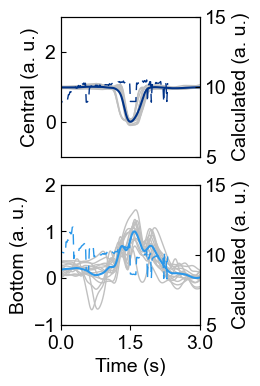

In [125]:
fig = plt.figure(figsize=(1.8, 4))

ax1_c = fig.add_subplot(211)
for sample in swallowing_m:
    ax1_c.plot(timestamps_m, sample[:, 0],
            lw=1, c='silver')
ax1_c.plot(timestamps_m, np.mean(swallowing_m, axis=0)[:, 0],
         lw=1.5, c=pv_color[0])    
ax1_c.set_xlim(0, 3)
ax1_c.set_ylim(-1, 3)
ax1_c.set_xticks([])
ax1_c.tick_params(axis='y', direction='in')
ax1_c.set_ylabel('Central (a. u.)')

ax2_c = ax1_c.twinx()
ax2_c.plot(-0.1 + (swallowing[:, 0] - swallowing[0, 0])/60, swallowing[:, 1],
         lw=1, ls=(0, (7.5, 5)), c=pv_color[0])
ax2_c.set_ylim(5, 15)
ax2_c.tick_params(axis='y', direction='in')
ax2_c.set_ylabel('Calculated (a. u.)')

ax1_b = fig.add_subplot(212)
for sample in swallowing_m:
    ax1_b.plot(timestamps_m, sample[:, 1],
            lw=1, c='silver')
ax1_b.plot(timestamps_m, np.mean(swallowing_m, axis=0)[:, 1],
         lw=1.5, c=pv_color[1])    
ax1_b.set_xlim(0, 3)
ax1_b.set_ylim(-1, 2)
ax1_b.set_xticks([0, 1.5, 3])
ax1_b.set_xlabel('Time (s)')
ax1_b.tick_params(axis='y', direction='in')
ax1_b.set_ylabel('Bottom (a. u.)')

ax2_b = ax1_b.twinx()
ax2_b.plot(-0.1 + (swallowing[:, 0] - swallowing[0, 0])/60, swallowing[:, 2]*2 - 13.5,
         lw=1, ls=(0, (7.5, 5)), c=pv_color[1])
ax2_b.set_ylim(5, 15)
ax2_b.tick_params(axis='y', direction='in')
ax2_b.set_ylabel('Calculated (a. u.)')

plt.savefig('swallowing.png', dpi=600, bbox_inches='tight')
plt.show()